# Mann Whitney U test

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

np.random.seed(18)


[I saw a tweet recently](https://twitter.com/MaartenvSmeden/status/1100382052367691776) that make me realize that many people are confused about the [Mann-Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test).  A common misconception is that it tests for a difference in medians.  Apparently that is true under a specific assumption, but not true in general.

I have never been confused about the Mann-Whitney U test, because I believe "There is Only One Test".  As I explain in [this article](https://allendowney.blogspot.com/2016/06/there-is-still-only-one-test.html), all hypothesis tests fit into a general framework; the only differences are:

1. The test statistic, and
2. A model of the null hypothesis.

If you have these two pieces, it is easy to compute the sampling distribution of the test statistic under the null hypothesis, and from that you can compute a p-value.

To demonstrate, I'll use this framework to implement a version of the Mann-Whitney U test.

### Example data

First I'll generate samples from two gamma distributions with slighly different parameters.

In [2]:
n1 = 90
n2 = 110

In [3]:
group1 = np.random.gamma(5, 0.5, size=n1)
group1.mean(), group1.std()

(2.62509416921364, 1.257132162349856)

In [4]:
group2 = np.random.gamma(4.9, 0.48, size=n2)
group2.mean(), group2.std()

(2.4520533570340324, 1.0190315744898875)

Here's what the distributions look like for the two groups.

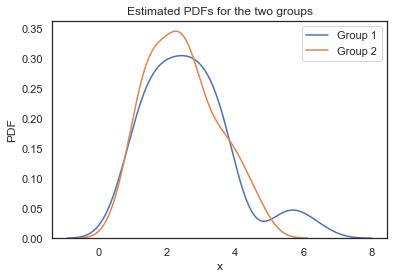

In [5]:
sns.kdeplot(group1, label='Group 1')
sns.kdeplot(group2, label='Group 2')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Estimated PDFs for the two groups');

### The test statistic

The test statistic for the Mann-Whitney U test is the probability of superiority; that is, if I choose a random observation from each group, what is the probability that the observation from Group 1 exceeds the observation from Group 2.

The following function takes two arrays representing the observed samples, and computes the probablity of superiority for Group 1 by comparing all pairs.  This is not the most efficient implementation, but it is easy to compute using one of NumPy's `outer` methods (one of my favorite under-used features).

In this example, because I sampled from a continuous distribution, the probability of a tie is small so I will ignore it.

In [6]:
def test_stat(data):
    """Compute probability of superiority
    
    data: tuple of arrays
    returns: float probability
    """
    group1, group2 = data
    array = np.greater.outer(group1, group2)
    return np.mean(array)

Here's the test statistic for the observed data.

In [7]:
data = group1, group2
actual = test_stat(data)
actual

0.5253535353535354

The test statistic is far enough from 0.5 to be suspicious, but it's not clear whether I would expect that to happen by chance.  That's the question we'll answer, but first we need a null hypothesis.

### The null hypothesis

There are several ways to model the null hypothesis.  A simple choice is to assume that both samples were drawn from the same distribution.

We can model that hypothesis by [permutation](https://en.wikipedia.org/wiki/Resampling_(statistics)#Permutation_tests); that is, we can combine the observations into a pool and then shuffle the pool.

The following function implements this model.  Each time it runs, it shuffles the pool, then splits it into two groups with the same sample sizes as the observed data.

In [8]:
n1 = len(group1)
pool = np.hstack(data)
    
def run_model():    
    np.random.shuffle(pool)
    return pool[:n1], pool[n1:]

Here's an example where we generate one batch of permuted data and compute the test statistic.

In [9]:
fake = run_model()

In [10]:
test_stat(fake)

0.45494949494949494

### The sampling distribution

To estimate the sampling distribution, we can run `run_model` and `test_stat` 1000 times and save the results. 

In [11]:
def sampling_dist(iters=1000):
    """Samples the distribution of the test statistic under the null hypothesis.

    iters: number of iterations

    returns: array
    """
    return [test_stat(run_model()) for _ in range(iters)]

In [12]:
sample = sampling_dist()

Here's what the distribution of the test statistic looks like under the null hypothesis.  The gray line shows the observed test statistic.

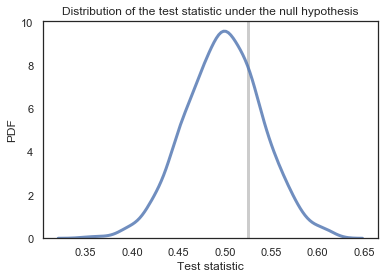

In [13]:
plt.axvline(actual, color='0.8', linewidth=3)
sns.kdeplot(sample, color='C0', linewidth=3, alpha=0.8)

plt.xlabel('Test statistic')
plt.ylabel('PDF')
plt.title('Distribution of the test statistic under the null hypothesis');

### The p-value

Finally, we can compute the p-value, which is the probability that the test statistic exceeds the observed value.

In [14]:
np.mean(sample > actual)

0.25

In this example, the p-value is fairly large, which means that the observed value (or higher) could plausibly occur even if the samples were drawn from the same distribution.

In other words, with these sample sizes, this test is not able to rule out the possibility that the observed difference between the groups is due to chance.